## Data loading

For our sentiment analysis we use EmoBank a large-scale text corpus manually annotated with emotion according to the psychological Valence-Arousal-Dominance scheme. https://github.com/JULIELab/EmoBank

In [8]:
import pandas as pd
df = pd.read_csv('data/EmoBank/corpus/emobank.csv')
df = df.drop(['id'], axis=1)
df.head()

,V,A,D,text
0,3.00,3.00,3.20,"Remember what she said in my last letter? """
1,2.80,3.10,2.80,If I wasn't working here.
2,3.00,3.00,3.00,".."""
3,3.44,3.00,3.22,Goodwill helps people get off of public assist...
4,3.55,3.27,3.46,Sherry learned through our Future Works class ...


The columns V, A and D represent Valence (negative vs. positive), Arousal (calm vs. excited), and Dominance (being controlled vs. being in control). Each of those take numeric values from [1, 5]

In [9]:
df.describe()

,V,A,D
count,10062.000000,10062.000000,10062.000000
mean,2.976690,3.041785,3.062763
std,0.348715,0.259541,0.209675
min,1.200000,1.800000,1.780000
25%,2.800000,2.890000,3.000000
50%,3.000000,3.000000,3.090000
75%,3.120000,3.200000,3.200000
max,4.600000,4.400000,4.200000


## Data processing

### Processing texts

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.25)

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()


def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

train['Processed_text'] = df.text.apply(lambda x: clean_text(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\XIAOMI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\XIAOMI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


C:\Users\XIAOMI\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
train.head()

,V,A,D,text,Processed_text
8020,2.73,2.82,3.00,I dimly remember three bedpartners who were pr...,dimly remember three bedpartners probably huma...
4407,3.12,3.25,3.25,The Coalition drafter letters to the Lykes Com...,coalition drafter letter lykes company ask gro...
3127,2.90,2.90,2.90,But what about Bay Area notables who like to c...,bay area notable like cook connect professiona...
6262,3.10,2.80,2.90,The 72-par course was designed by Dave Thomas.,72par course wa design dave thomas
6728,3.10,3.10,3.00,The small Chapel of St. Francis Xavier is dedi...,small chapel st francis xavier dedicate 16thce...


In [13]:
train.Processed_text.apply(lambda x: len(x.split(" "))).mean()

8.719321494831698

### Model

## Soon...

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers

max_features = 6000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(train['Processed_text'])
list_tokenized_train = tokenizer.texts_to_sequences(train['Processed_text'])

maxlen = 13
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
y = train.A

embed_size = 12
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])

batch_size = 100
epochs = 50
history = model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 6036 samples, validate on 1510 samples
Epoch 1/50
6036/6036 [==============================] - 4s 715us/step - loss: 3.8526 - mean_absolute_error: 1.6246 - mean_squared_error: 3.8526 - val_loss: 0.1790 - val_mean_absolute_error: 0.3401 - val_mean_squared_error: 0.1790
Epoch 2/50
6036/6036 [==============================] - 1s 174us/step - loss: 0.1615 - mean_absolute_error: 0.3168 - mean_squared_error: 0.1615 - val_loss: 0.0811 - val_mean_absolute_error: 0.2252 - val_mean_squared_error: 0.0811
Epoch 3/50
6036/6036 [==============================] - 1s 173us/step - loss: 0.1320 - mean_absolute_error: 0.2816 - mean_squared_error: 0.1320 - val_loss: 0.0708 - val_mean_absolute_error: 0.2087 - val_mean_squared_error: 0.0708
Epoch 4/50
6036/6036 [==============================] - 1s 173us/step - loss: 0.1204 - mean_absolute_error: 0.2663 - mean_squared_error: 0.1204 - val_loss: 0.0673 - val_mean_absolute_error: 0.2010 - val_mean_squared_error: 0.0673
Epoch 5/50
6036/6036 [==========

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['mean_squared_error'])
#plt.plot(history.history['acc'])
plt.show()

<Figure size 640x480 with 1 Axes>

In [16]:
df_test=test
df_test.head()
df_test["text"]=df_test.text.apply(lambda x: clean_text(x))
y_test = df_test.A
list_sentences_test = df_test["text"]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
prediction = model.predict(X_te)

C:\Users\XIAOMI\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
list(zip(y_test, prediction))
train.sort_values('A').tail(100)

,V,A,D,text,Processed_text
7212,4.10,3.80,3.40,“Welcome back!”,welcome back
7170,2.70,3.80,3.00,"First,sign and return your Petition to the Sec...",firstsign return petition secretary agricultur...
5757,2.30,3.80,3.30,"""What in G-d's name could have possessed you t...",gd name could possess thing cry arthur nearly ...
7564,3.60,3.80,3.20,He's had shows in Brazil and New Madrid and ev...,show brazil new madrid everywhere
3383,2.00,3.80,2.90,That just unnerved me more.,unnerve
369,3.50,3.80,3.20,What a Summer!,summer
3814,3.80,3.80,3.50,Even the city feels alive when spring comes.”,even city feel alive spring come
7213,3.90,3.80,3.40,All of us are excited about sending you your m...,u excite send magazine membership material
2542,3.40,3.80,3.60,Whether it is to fund additional land for the ...,whether fund additional land addo elephant par...
3910,3.90,3.80,3.30,We kissed and slipped inside.,kiss slip inside


In [18]:
def get_sentiment(text):
    cleaned_text = clean_text(text)
    print(cleaned_text)
    tokenized_text = tokenizer.texts_to_sequences([cleaned_text])
    x = pad_sequences(tokenized_text, maxlen=maxlen)
    return model.predict(x)

In [19]:
with open('sample.txt') as f:
    sample = f.read()
    predict = get_sentiment("police!")
    print(predict)

police
[[3.4021468]]


### Let's take pretrained imdb model

In [64]:
from keras.models import load_model
import pickle

pretrained_model = load_model('imdb_model1.h5')

with open('tokenizer.pickle', 'rb') as handle:
    pretrained_tokenizer = pickle.load(handle)

In [61]:
pretrained_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         768000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 64)          41216     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 810,537
Trainable params: 810,537
Non-trainable params: 0
_________________________________________________________________


In [54]:
print(train.sort_values('A',ascending=False).text[:10])

7787                             "My God, yes, yes, yes!"
8269                     DETROIT POLICE ARE WATCHING YOU!
7949                     I hate it, despise it, abhor it!
9393                       Happy Holidays from all of us!
1391                                                 Wow.
3570                                          “Oh, shit!”
5466          News Baby pandas! Baby pandas! Baby pandas!
2859    I'm very excited we'll be on the same team for...
4111                                      “No, I saw him!
8310                                              $1,900!
Name: text, dtype: object


In [91]:
# model.predict()
def get_sentiment1(text):
    cleaned_text = clean_text(text)
    #print(cleaned_text)
    tokenized_text = pretrained_tokenizer.texts_to_sequences([cleaned_text])
    x = pad_sequences(tokenized_text, maxlen=maxlen)
    return pretrained_model.predict(x)

get_sentiment1("cayogial i wanted to come to BZ this summer :/ not so sure anymore... a teacher's life in the summer awful")

array([[0.1926185]], dtype=float32)

### and new dataset

In [80]:
twitter_dataset = pd.read_csv('data/twitter/text_emotion.csv')
twitter_dataset = twitter_dataset.drop(['tweet_id', 'author'], axis=1)
twitter_dataset.head(-5)

,sentiment,content
0,empty,@tiffanylue i know i was listenin to bad habi...
1,sadness,Layin n bed with a headache ughhhh...waitin o...
2,sadness,Funeral ceremony...gloomy friday...
3,enthusiasm,wants to hang out with friends SOON!
4,neutral,@dannycastillo We want to trade with someone w...
5,worry,Re-pinging @ghostridah14: why didn't you go to...
6,sadness,"I should be sleep, but im not! thinking about ..."
7,worry,Hmmm. http://www.djhero.com/ is down
8,sadness,@charviray Charlene my love. I miss you
9,sadness,@kelcouch I'm sorry at least it's Friday?


In [165]:
twitter_dataset.sentiment.unique().size

13

In [92]:
twitter_dataset['sentiment'] = twitter_dataset.content.apply(get_sentiment1[0][0])
twitter_dataset.head()

,sentiment,content
0,[[0.27743703]],@tiffanylue i know i was listenin to bad habi...
1,[[0.19975024]],Layin n bed with a headache ughhhh...waitin o...
2,[[0.6554246]],Funeral ceremony...gloomy friday...
3,[[0.68056506]],wants to hang out with friends SOON!
4,[[0.40516263]],@dannycastillo We want to trade with someone w...


In [103]:
#twitter_dataset.sentiment = twitter_dataset.sentiment.apply(lambda x: x[0][0])
twitter_dataset.head(100)
#twitter_dataset.rename({'sentiment':'imdb_result'}, inplace=True)
twitter_dataset["imdb_result"] = twitter_dataset.sentiment
df = pd.read_csv('data/twitter/text_emotion.csv')
twitter_dataset["sentiment"] = df.sentiment
twitter_dataset.head()

,sentiment,content,imdb_result
0,empty,@tiffanylue i know i was listenin to bad habi...,0.277437
1,sadness,Layin n bed with a headache ughhhh...waitin o...,0.199750
2,sadness,Funeral ceremony...gloomy friday...,0.655425
3,enthusiasm,wants to hang out with friends SOON!,0.680565
4,neutral,@dannycastillo We want to trade with someone w...,0.405163


In [113]:
get_sentiment1("Funeral ceremony...gloomy friday... Funeral ceremony... gloomy friday... Funeral ceremony... gloomy friday... Funeral ceremony... gloomy friday...")

array([[0.80134475]], dtype=float32)

### Analyze results

In [118]:
df = twitter_dataset.copy()
df.head()

,sentiment,content,imdb_result
0,empty,@tiffanylue i know i was listenin to bad habi...,0.277437
1,sadness,Layin n bed with a headache ughhhh...waitin o...,0.199750
2,sadness,Funeral ceremony...gloomy friday...,0.655425
3,enthusiasm,wants to hang out with friends SOON!,0.680565
4,neutral,@dannycastillo We want to trade with someone w...,0.405163


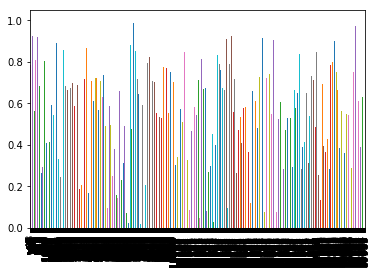

In [133]:
sad = df.loc[df['sentiment'] == 'sadness'].imdb_result
sad.plot(kind='bar')

empty


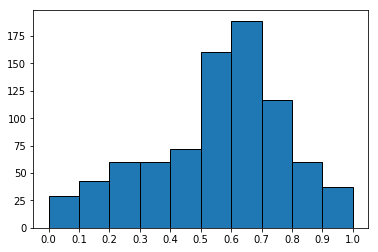

sadness


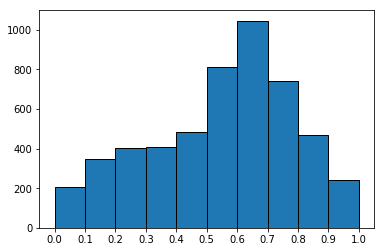

enthusiasm


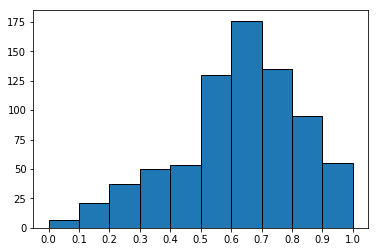

neutral


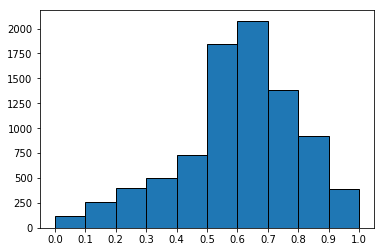

worry


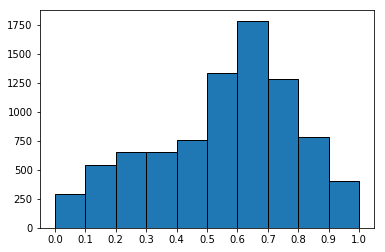

surprise


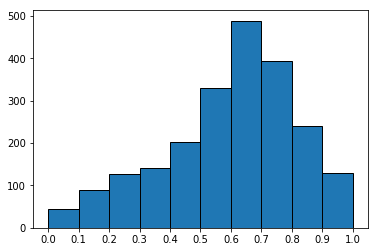

love


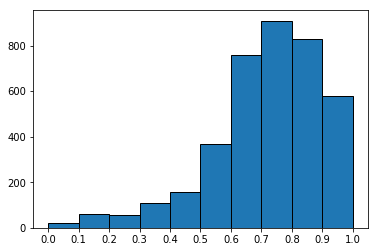

fun


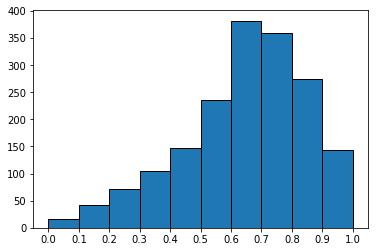

hate


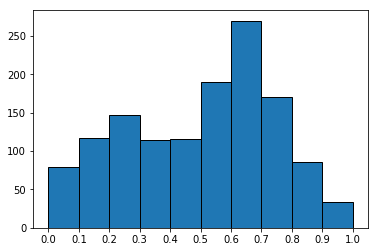

happiness


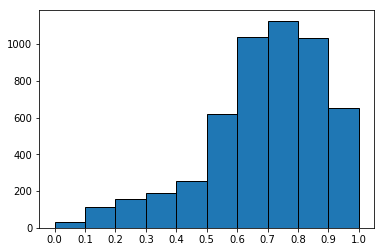

boredom


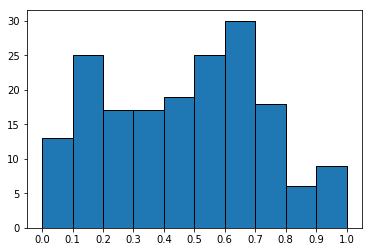

relief


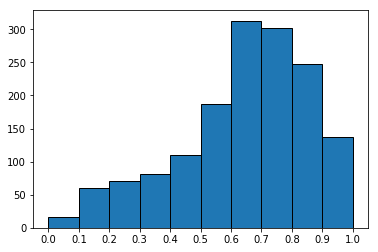

anger


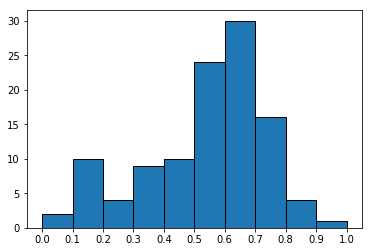

In [139]:
import matplotlib.pyplot as plt 

sentiments_name = twitter_dataset.sentiment.unique()

for s in sentiments_name:
    print(s)
    sad = df.loc[df['sentiment'] == s].imdb_result
    bins= [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    plt.hist(sad.values, bins=bins, edgecolor="k")
    plt.xticks(bins)
    plt.show()

#### Preparing data

In [217]:
twitter_dataset.head()
#df = pd.get_dummies(twitter_dataset, columns=['sentiment'])
df = twitter_dataset.drop(columns=['imdb_result'])
df['processed_data'] = df.content.apply(clean_text)

In [218]:
df.head()

,sentiment,content,processed_data
0,empty,@tiffanylue i know i was listenin to bad habi...,tiffanylue know wa listenin bad habit earlier...
1,sadness,Layin n bed with a headache ughhhh...waitin o...,layin n bed headache ughhhhwaitin call
2,sadness,Funeral ceremony...gloomy friday...,funeral ceremonygloomy friday
3,enthusiasm,wants to hang out with friends SOON!,want hang friend soon
4,neutral,@dannycastillo We want to trade with someone w...,dannycastillo want trade someone ha houston ti...


In [219]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

In [164]:
from keras.models import Model
new_model = Model(inputs=pretrained_model.inputs, outputs = pretrained_model.layers[-2].output)

In [224]:
x = new_model.output
predictions = Dense(13, activation="softmax")(x)
model_final1 = Model(input = new_model.input, output = predictions)

for layer1 in model_final1.layers[:-1]:
    layer.trainable = False
    
model_final1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

C:\Users\XIAOMI\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("em..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [223]:
model_final1.layers[-1].get_weights()

[array([[-0.24421668, -0.16020858, -0.13397846, -0.337987  , -0.14157322,
         -0.0221734 , -0.3602533 ,  0.03112677,  0.17588204,  0.09294033,
          0.18947822,  0.22406888,  0.15010816],
        [ 0.28967333, -0.15390605,  0.17359269, -0.31240445,  0.16899657,
          0.14907241,  0.33998752,  0.13861221, -0.19934388,  0.28933328,
          0.4003865 , -0.0971773 , -0.08353549],
        [ 0.07457042, -0.01947042, -0.3344755 , -0.15900326, -0.33895338,
         -0.3846947 , -0.31036645, -0.06587434,  0.111803  , -0.27054155,
          0.37028563,  0.25722504, -0.35545385],
        [ 0.3670476 ,  0.10296613, -0.37557775, -0.3772389 ,  0.3067333 ,
         -0.38565907, -0.2198424 ,  0.15470672,  0.05342299,  0.1312241 ,
         -0.10086501, -0.08014131, -0.08852497],
        [-0.15709263,  0.31402862, -0.16254893, -0.4150469 , -0.28617036,
         -0.02891198,  0.3005091 ,  0.1857034 ,  0.35754395, -0.14389649,
         -0.01620382,  0.02197647, -0.13186297],
        [ 0.129

In [225]:
list_tokenized_train = pretrained_tokenizer.texts_to_sequences(train['processed_data'])
max(list_tokenized_train, key=len)
list_tok_train = []
for l in list_tokenized_train:
    list_tok_train.append(l*10)
list_tok_train

[[244,
  757,
  26,
  244,
  757,
  26,
  244,
  757,
  26,
  244,
  757,
  26,
  244,
  757,
  26,
  244,
  757,
  26,
  244,
  757,
  26,
  244,
  757,
  26,
  244,
  757,
  26,
  244,
  757,
  26],
 [143,
  1897,
  222,
  69,
  26,
  143,
  1897,
  222,
  69,
  26,
  143,
  1897,
  222,
  69,
  26,
  143,
  1897,
  222,
  69,
  26,
  143,
  1897,
  222,
  69,
  26,
  143,
  1897,
  222,
  69,
  26,
  143,
  1897,
  222,
  69,
  26,
  143,
  1897,
  222,
  69,
  26,
  143,
  1897,
  222,
  69,
  26,
  143,
  1897,
  222,
  69,
  26],
 [25,
  812,
  475,
  50,
  470,
  25,
  812,
  475,
  50,
  470,
  25,
  812,
  475,
  50,
  470,
  25,
  812,
  475,
  50,
  470,
  25,
  812,
  475,
  50,
  470,
  25,
  812,
  475,
  50,
  470,
  25,
  812,
  475,
  50,
  470,
  25,
  812,
  475,
  50,
  470,
  25,
  812,
  475,
  50,
  470,
  25,
  812,
  475,
  50,
  470],
 [5,
  41,
  2598,
  10,
  1219,
  9,
  111,
  28,
  937,
  9,
  2085,
  2407,
  5,
  41,
  2598,
  10,
  1219,
  9,
  111,
  2

In [227]:
X_t = pad_sequences(list_tok_train, maxlen=130)
y_train = pd.get_dummies(train.sentiment)
batch_size = 100
epochs = 3

model_final1.fit(X_t,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 25600 samples, validate on 6400 samples
Epoch 1/3
25600/25600 [==============================] - 27s 1ms/step - loss: 2.3679 - acc: 0.2126 - val_loss: 2.1906 - val_acc: 0.2327
Epoch 2/3
25600/25600 [==============================] - 24s 952us/step - loss: 2.1854 - acc: 0.2359 - val_loss: 2.1563 - val_acc: 0.2331
Epoch 3/3
25600/25600 [==============================] - 23s 883us/step - loss: 2.1627 - acc: 0.2353 - val_loss: 2.1423 - val_acc: 0.2345


In [239]:
list_tokenized_test = pretrained_tokenizer.texts_to_sequences(test['processed_data'])
list_tok_test = []
for l in list_tokenized_train:
    list_tok_test.append(l*10)
X_te = pad_sequences(list_tokenized_test, maxlen=130)
y_test = pd.get_dummies(test.sentiment)
y_pred = model_final1.predict(X_te)
# from sklearn.metrics import f1_score, confusion_matrix
# print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
# print('Confusion matrix:')
# confusion_matrix(y_pred, y_test)

In [247]:
import numpy as np
pred = np.argmax(y_pred, axis=1)
real = np.argmax(y_test.values, axis=1)
from sklearn.metrics import f1_score, confusion_matrix
print('F1-score: {0}'.format(f1_score(pred, real, average='micro')))
print('Confusion matrix:')
confusion_matrix(pred, real)

F1-score: 0.23625
Confusion matrix:


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    1,    1,    8,    0,    5,    8,    5,    1,
           1,    4],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [  15,   24,  148,  133,  329,  992,  185,  733, 1563,  287,  846,
         373, 1405],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 

### Train full model

In [252]:
embed_size = 30
model2 = Sequential()
model2.add(Embedding(6000, embed_size))
model2.add(Bidirectional(LSTM(8, return_sequences = True)))
model2.add(GlobalMaxPool1D())
model2.add(Dense(20, activation="relu"))
model2.add(Dropout(0.05))
model2.add(Dense(13, activation="sigmoid"))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 100
epochs = 10
model2.fit(X_t,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 25600 samples, validate on 6400 samples
Epoch 1/10
25600/25600 [==============================] - 25s 973us/step - loss: 2.2532 - acc: 0.2091 - val_loss: 2.1319 - val_acc: 0.2080
Epoch 2/10
25600/25600 [==============================] - 26s 1ms/step - loss: 2.1147 - acc: 0.2125 - val_loss: 2.1143 - val_acc: 0.2111
Epoch 3/10
25600/25600 [==============================] - 25s 977us/step - loss: 2.0759 - acc: 0.2540 - val_loss: 2.1103 - val_acc: 0.2578
Epoch 4/10
25600/25600 [==============================] - 26s 1ms/step - loss: 2.0327 - acc: 0.2778 - val_loss: 2.0842 - val_acc: 0.2813
Epoch 5/10
25600/25600 [==============================] - 28s 1ms/step - loss: 1.9656 - acc: 0.3176 - val_loss: 2.0458 - val_acc: 0.2988
Epoch 6/10
25600/25600 [==============================] - 28s 1ms/step - loss: 1.8858 - acc: 0.3539 - val_loss: 2.0298 - val_acc: 0.3077
Epoch 7/10
25600/25600 [==============================] - 26s 1ms/step - loss: 1.8279 - acc: 0.3783 - val_loss: 2.0417 - val_

In [253]:
y_pred = model2.predict(X_te)
pred = np.argmax(y_pred, axis=1)
real = np.argmax(y_test.values, axis=1)
print('F1-score: {0}'.format(f1_score(pred, real, average='micro')))
print('Confusion matrix:')
confusion_matrix(pred, real)

F1-score: 0.246
Confusion matrix:


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    1,    0,    2,    8,    0,    5,    2,    2,    5,
           2,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   1,    1,    3,    1,   13,   44,    1,  208,   25,   11,   17,
          10,   37],
       [  20,   29,  170,  145,  337,  996,  235,  542, 1698,  307,  948,
         399, 1640],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,    0,    0,    1,    1,    3, 

### Let's try some embedding

In [2]:
MAX_NB_WORDS = 40000 # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 30 # max length of text (words) including padding
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 200 # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "data/demo/glove.twitter.27B."+str(200)+"d.txt"

In [3]:
import csv
texts, labels = [], []
print("[i] Reading from csv file...", end="")
with open('data/demo/data.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        texts.append(row[0])
        labels.append(row[1])
print("Done!")

[i] Reading from csv file...Done!


In [4]:
len(texts)

47288

Dataset has been labeled on 5 emotions: "Neutral", "Happy", "Sad", "Hate", "Anger"

In [260]:
texts

['do not get angry or frustrated or desperate or enraged or depressed or any such thing you are all e',
 'sickening i hurt for florida later for the what if s and i know how they feel no you don t i can t imagin',
 'this rainfall is a savage y fall when am in d club n when am home its hot like hell without no light angry',
 'angry guy screws his gf in very rude manner portsmouth',
 'silence is better when you re angry and frustrated reacting to it will fuel the pain',
 'it s your smile which makes me cool and calm when i am sad or angry smile cool calm sad angry edits by birdies yo',
 'disappointed w ur new hair policies if ppl cant understand the above below the chin they have issues',
 'mt drama school audition tip see angry while you can it is a masterclass in monologue delivery from young actor',
 'go and see this angry by philip ridley absolutely brilliant unconventional unexpected and raw',
 'wanna come a blog from me q a photos live tweeting getting angry with philip ridley',
 '

In [261]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
with open('tokenizerv1.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("[i] Saved word tokenizer to file: tokenizerv1.pickle")

[i] Saved word tokenizer to file: tokenizerv1.pickle


In [262]:
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('[i] Found %s unique tokens.' % len(word_index))
data_int = pad_sequences(sequences, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
data = pad_sequences(data_int, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))

[i] Found 34359 unique tokens.


In [264]:
from keras.utils.np_utils import to_categorical
labels = to_categorical(np.asarray(labels)) # convert to one-hot encoding vectors
print('[+] Shape of data tensor:', data.shape)
print('[+] Shape of label tensor:', labels.shape)

[+] Shape of data tensor: (47288, 30)
[+] Shape of label tensor: (47288, 5)


In [266]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

In [267]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [275]:
embeddings_index = {}
f = open(GLOVE_DIR,  encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [276]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# static channel
embedding_layer_frozen = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
embedded_sequences_frozen = embedding_layer_frozen(sequence_input)

In [277]:
lstm_1 = (Bidirectional(LSTM(32, return_sequences = True)))(embedded_sequences_frozen)
pool_1 = (GlobalMaxPool1D())(lstm_1)
dense_1 = (Dense(20, activation="relu"))(pool_1)
dropout_1 = (Dropout(0.05))(dense_1)
preds = (Dense(5, activation="softmax"))(dropout_1)

advanced_model = Model(sequence_input, preds)
advanced_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 100
epochs = 10
advanced_model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Train on 30264 samples, validate on 7567 samples
Epoch 1/10
30264/30264 [==============================] - 13s 426us/step - loss: 1.1084 - acc: 0.5332 - val_loss: 0.9714 - val_acc: 0.5973
Epoch 2/10
30264/30264 [==============================] - 14s 472us/step - loss: 0.9321 - acc: 0.6185 - val_loss: 0.9279 - val_acc: 0.6166
Epoch 3/10
30264/30264 [==============================] - 14s 472us/step - loss: 0.8926 - acc: 0.6341 - val_loss: 0.9424 - val_acc: 0.6049
Epoch 4/10
30264/30264 [==============================] - 14s 470us/step - loss: 0.8679 - acc: 0.6474 - val_loss: 0.9235 - val_acc: 0.6207
Epoch 5/10
30264/30264 [==============================] - 14s 475us/step - loss: 0.8445 - acc: 0.6563 - val_loss: 0.9239 - val_acc: 0.6172
Epoch 6/10
30264/30264 [==============================] - 14s 468us/step - loss: 0.8220 - acc: 0.6670 - val_loss: 0.9374 - val_acc: 0.6096
Epoch 7/10
30264/30264 [==============================] - 14s 472us/step - loss: 0.7981 - acc: 0.6782 - val_loss: 0.9

In [283]:
y_pred_adv = advanced_model.predict(x_val)
pred_adv = np.argmax(y_pred_adv, axis=1)
real_adv = np.argmax(y_val, axis=1)
print('F1-score: {0}'.format(f1_score(pred_adv, real_adv, average='micro')))
print('Confusion matrix:')
confusion_matrix(pred_adv, real_adv)

F1-score: 0.6170032779951359
Confusion matrix:


array([[ 672,  367,  316,   36,    9],
       [ 534, 2124,  503,   30,   12],
       [ 665,  720, 2254,  183,   44],
       [  39,   35,   97,  624,    7],
       [   5,    4,    7,    9,  161]], dtype=int64)

In [309]:
from sklearn.metrics import classification_report, confusion_matrix
classes = ["neutral", "happy", "sad", "hate","anger"]
print(classification_report(pred_adv, real_adv, target_names=classes))

              precision    recall  f1-score   support

     neutral       0.35      0.48      0.41      1400
       happy       0.65      0.66      0.66      3203
         sad       0.71      0.58      0.64      3866
        hate       0.71      0.78      0.74       802
       anger       0.69      0.87      0.77       186

   micro avg       0.62      0.62      0.62      9457
   macro avg       0.62      0.67      0.64      9457
weighted avg       0.64      0.62      0.62      9457



In [312]:
def predict_emotion(text):
    sequences = tokenizer.texts_to_sequences([text])
    word_index = tokenizer.word_index
    data_int = pad_sequences(sequences, padding='pre', maxlen=(MAX_SEQUENCE_LENGTH-5))
    data = pad_sequences(data_int, padding='post', maxlen=(MAX_SEQUENCE_LENGTH))
    prediction_ar = advanced_model.predict(data)
    pr = np.argmax(prediction_ar, axis=1)
    print(prediction_ar)
    if pr == 0:
        return "Neutral"
    if pr == 1:
        return "Happy"
    if pr == 2:
        return "Sad"
    if pr == 3:
        return "Hate"
    if pr == 4:
        return "Anger"
    return pr

print(predict_emotion("What a lovely day! What a lovely day! What a lovely day!"))
print(predict_emotion("I hate you"))
print(predict_emotion("A king in the castle"))
print(predict_emotion("i am so sorry for what happened!"))
print(predict_emotion("I'm angry of you!"))

print(predict_emotion("The program normally began to work only in the morning!!"))

[[7.8846253e-02 8.6795175e-01 5.2069455e-02 9.0845209e-04 2.2403678e-04]]
Happy
[[0.05122793 0.01296184 0.16364405 0.77134866 0.00081756]]
Hate
[[7.0200390e-01 2.4488537e-01 4.9346332e-02 3.2590840e-03 5.0535431e-04]]
Neutral
[[6.1714277e-02 1.0082791e-01 8.3557051e-01 1.4421572e-03 4.4520298e-04]]
Sad
[[0.00957626 0.00163886 0.01327656 0.00104325 0.97446513]]
Anger
[[7.43215978e-01 1.41243577e-01 1.12104796e-01 2.80372961e-03
  6.31935953e-04]]
Neutral


In [318]:
print(predict_emotion("""When you were here before
Couldn't look you in the eye
You're just like an angel
Your skin makes me cry
You float like a feather
In a beautiful world
And I wish I was special
You're so fuckin' special
But I'm a creep, I'm a weirdo.
What the hell am I doing here?
I don't belong here.
I don't care if it hurts
I want to have control
I want a perfect body
I want a perfect soul
I want you to notice
When I'm not around
You're so fuckin' special
I wish I was special
But I'm a creep, I'm a weirdo.
What the hell am I doing here?
I don't belong here.
She's running out again,
She's running out
She's run run run run
Whatever makes you happy
Whatever you want
You're so fuckin' special
I wish I was special
But I'm a creep, I'm a weirdo,
What the hell am I doing here?
I don't belong here.
I don't belong here."""))

[[0.16698217 0.23685727 0.5202491  0.07424202 0.00166946]]
Sad
